# Diatom Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<a target="_blank"  href="https://colab.research.google.com/github/rtharungowda/nnc/blob/main/diatom_instance_segmentation.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab - Instance segmentation
</a>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
workspace = 'Colab'
workspace = 'Locally'
if workspace == 'Colab':
    # install dependencies: 
    !pip install pyyaml==5.1
    import torch, torchvision
    print(torch.__version__, torch.cuda.is_available())
    !gcc --version
    # opencv is pre-installed on colab

In [2]:
if workspace == 'Colab':
    # install detectron2: (Colab has CUDA 10.1 + torch 1.8)
    # See https://detectron2.readthedocs.io/tutorials/install.html for instructions
    import torch
    assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes it s default version
    !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
    # exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

In [3]:
!git clone https://github.com/rtharungowda/nnc.git

fatal: destination path 'nnc' already exists and is not an empty directory.


## Get data

In [4]:
if workspace == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/home/alon/Projects/alon/reserach/Digital-Bacillaria/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [6]:
# DatasetCatalog.remove('diatom_seg_train')

In [7]:
from detectron2.data.datasets import register_coco_instances

if workspace == 'Colab':
    nnc_data = "/content/nnc/Dataset/30_bbg_inst_sgm"
else:
    nnc_data = "nnc/Dataset/30_bbg_inst_sgm"
for d in ["train", "test"]:
    register_coco_instances(f"diatom_seg_{d}", {}, f"{nnc_data}/annotations/diatom_seg_{d}.json", f"{nnc_data}/images/")

WARNING [08/28 23:02:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/28 23:02:25 d2.data.datasets.coco]: Loaded 24 images in COCO format from nnc/Dataset/30_bbg_inst_sgm/annotations/diatom_seg_train.json


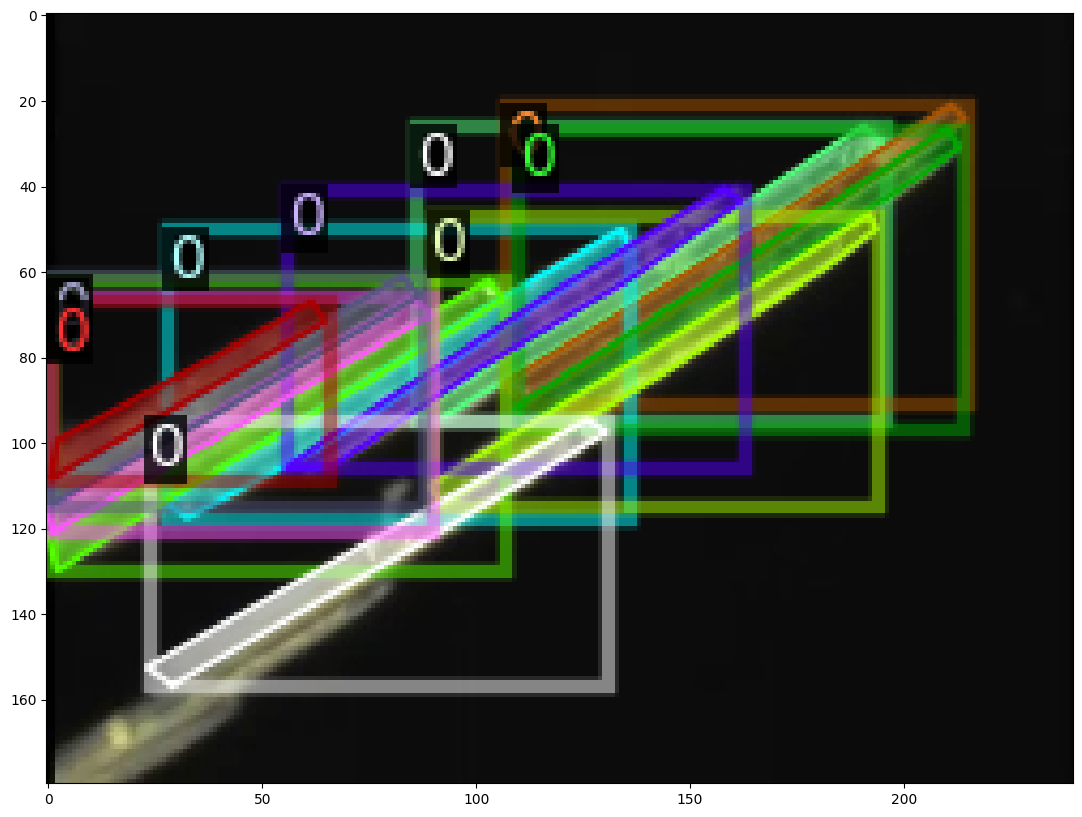

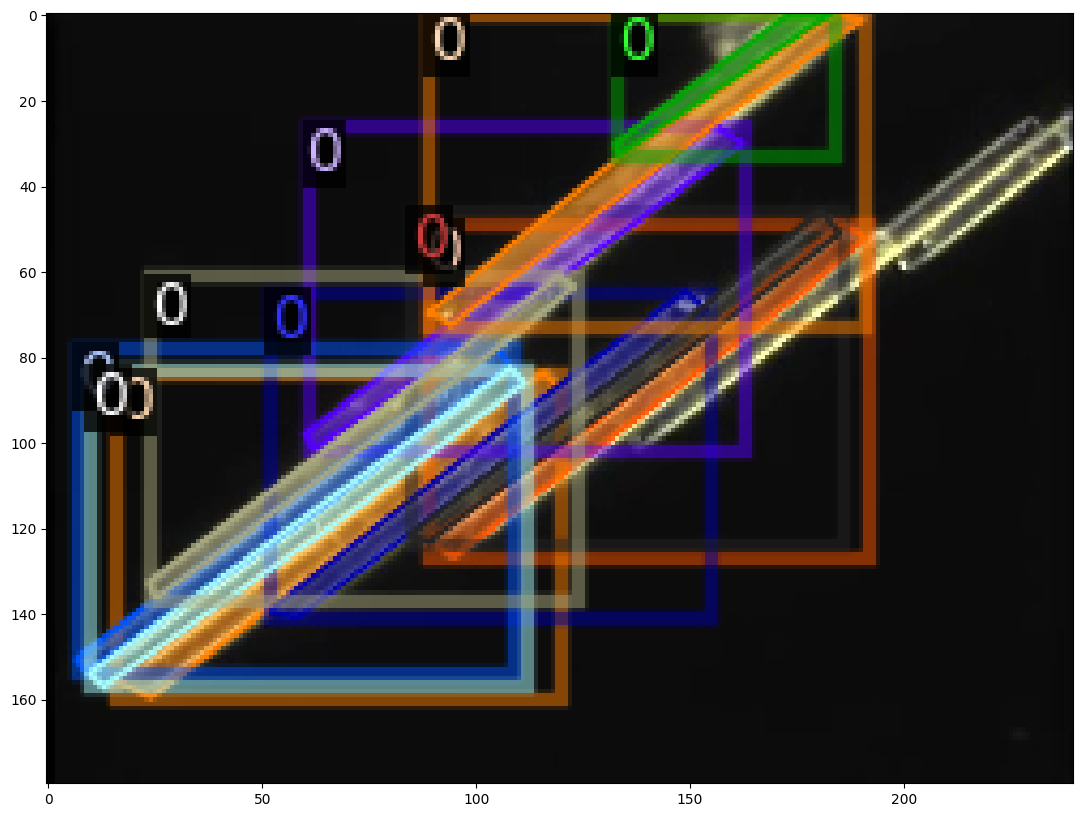

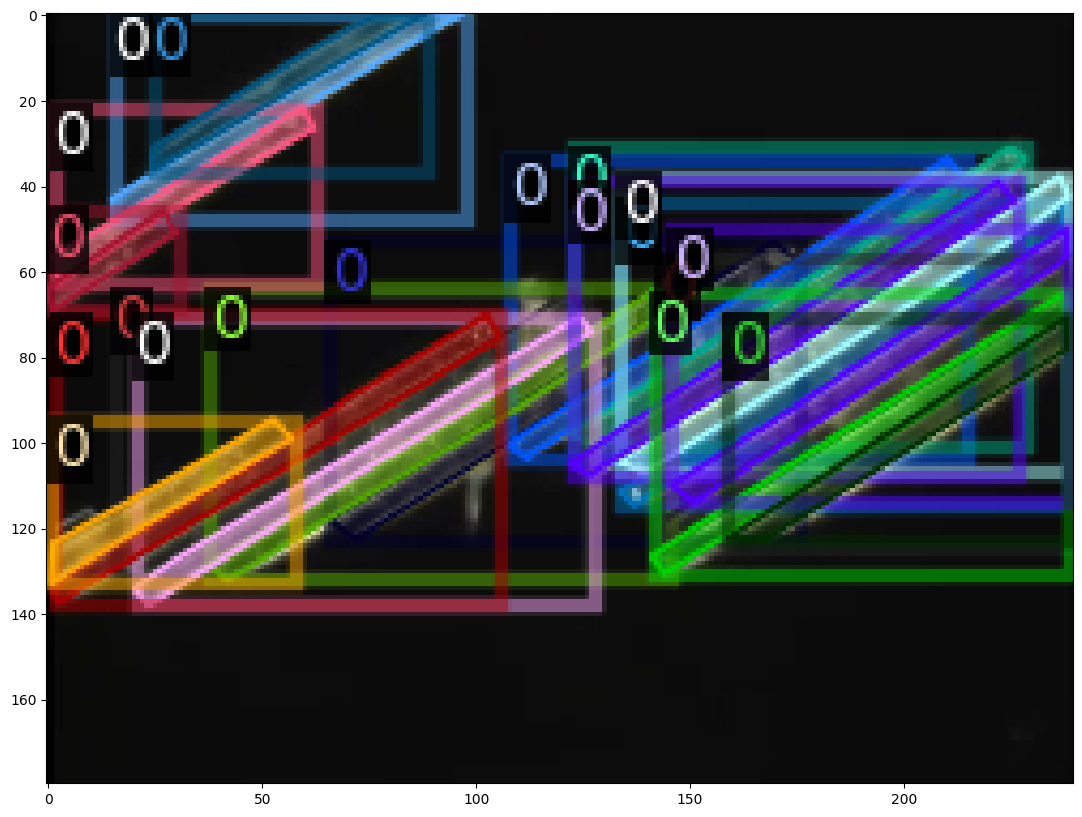

In [8]:
import random

dataset_dicts = DatasetCatalog.get("diatom_seg_train")
microcontroller_metadata = MetadataCatalog.get("diatom_seg_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the diatom data-set.

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("diatom_seg_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/28 23:02:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[08/28 23:02:27 d2.engine.train_loop]: Starting training from iteration 0


/home/alon/Projects/alon/reserach/Digital-Bacillaria/.venv/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[08/28 23:02:32 d2.utils.events]:  eta: 0:30:17  iter: 19  total_loss: 2.645  loss_cls: 0.5952  loss_box_reg: 0.8673  loss_mask: 0.6904  loss_rpn_cls: 0.4372  loss_rpn_loc: 0.09083  time: 0.1815  data_time: 0.0055  lr: 4.9953e-06  max_mem: 2551M
[08/28 23:02:36 d2.utils.events]:  eta: 0:31:09  iter: 39  total_loss: 2.531  loss_cls: 0.574  loss_box_reg: 0.8715  loss_mask: 0.6701  loss_rpn_cls: 0.2797  loss_rpn_loc: 0.1074  time: 0.1860  data_time: 0.0026  lr: 9.9902e-06  max_mem: 2551M
[08/28 23:02:40 d2.utils.events]:  eta: 0:30:53  iter: 59  total_loss: 2.237  loss_cls: 0.5169  loss_box_reg: 0.8422  loss_mask: 0.6324  loss_rpn_cls: 0.152  loss_rpn_loc: 0.08227  time: 0.1846  data_time: 0.0025  lr: 1.4985e-05  max_mem: 2560M
[08/28 23:02:43 d2.utils.events]:  eta: 0:30:44  iter: 79  total_loss: 2.082  loss_cls: 0.4689  loss_box_reg: 0.8464  loss_mask: 0.579  loss_rpn_cls: 0.08539  loss_rpn_loc: 0.07092  time: 0.1843  data_time: 0.0025  lr: 1.998e-05  max_mem: 2560M
[08/28 23:02:47 d2.u

Tensorboard

In [14]:
# Look at training curves in tensorboard:
%load_ext tensorboard
if workspace == 'Colab':
    %tensorboard --logdir /content/nnc/output/
else:
    %tensorboard --logdir $cfg.OUTPUT_DIR

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0009999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4 
cfg.DATASETS.TEST = ("diatom_seg_test", )
predictor = DefaultPredictor(cfg)

[08/28 23:35:02 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

WARNING [08/28 23:35:02 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/28 23:35:02 d2.data.datasets.coco]: Loaded 24 images in COCO format from nnc/Dataset/30_bbg_inst_sgm/annotations/diatom_seg_train.json


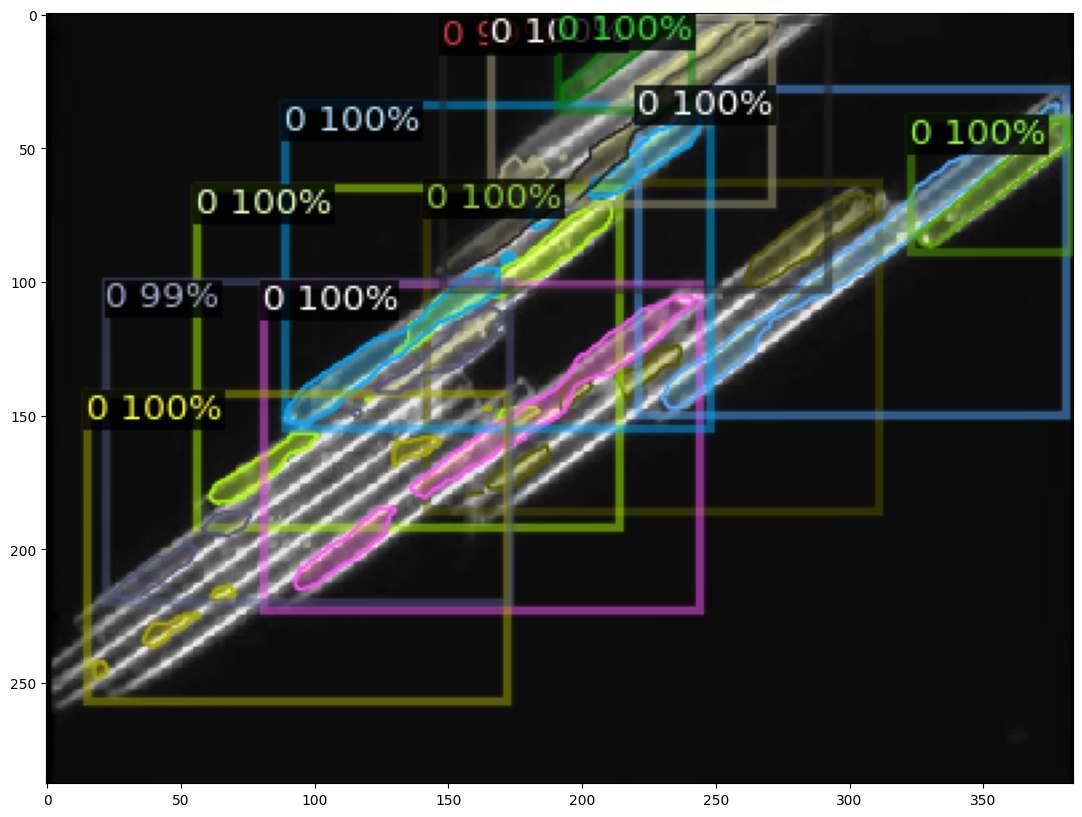

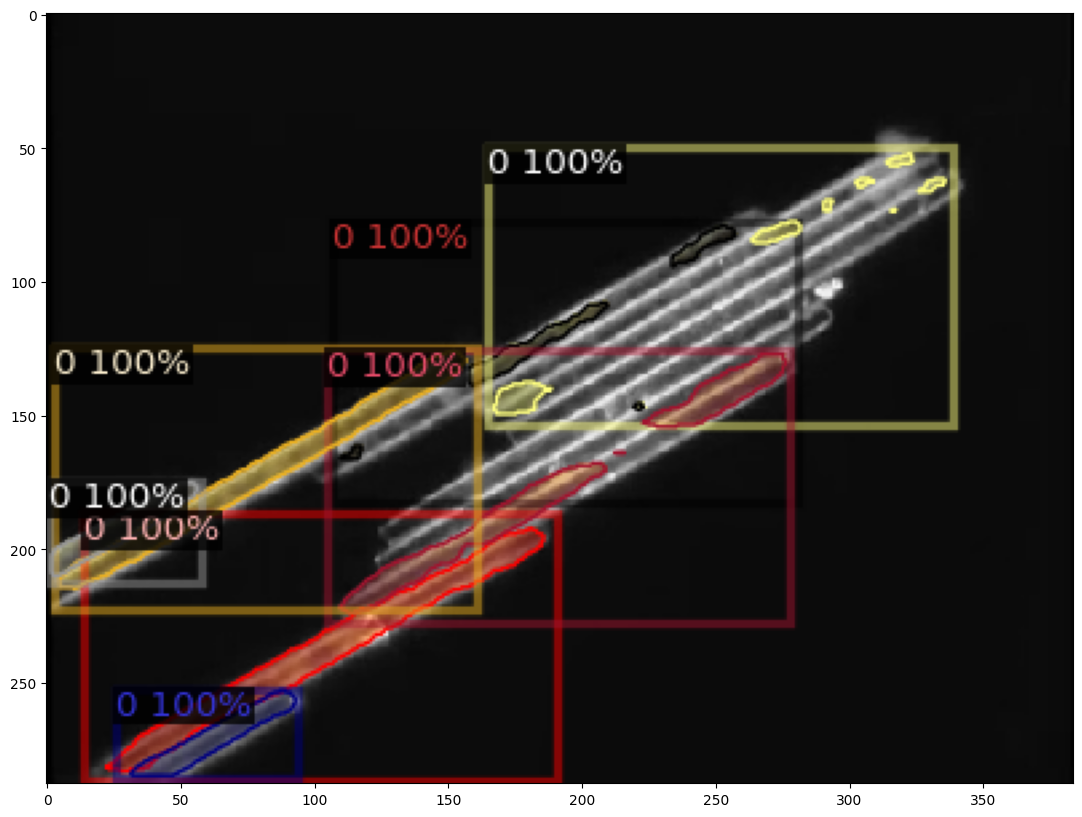

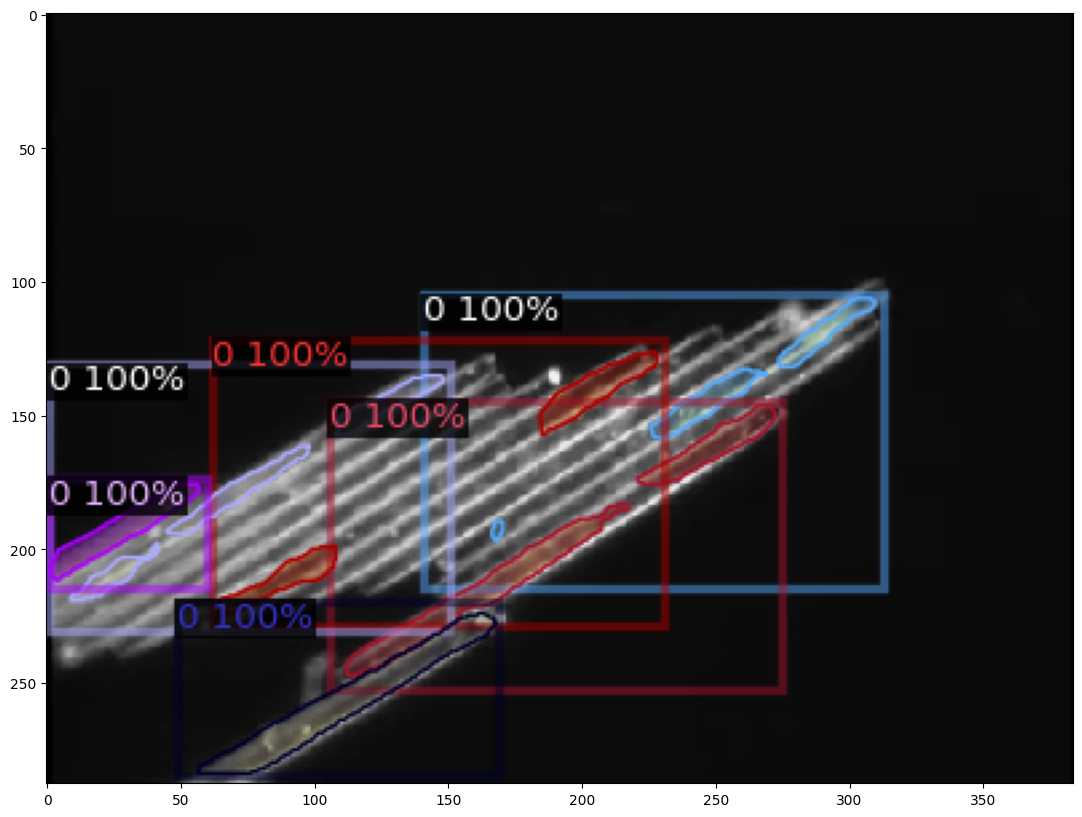

In [12]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("diatom_seg_train")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

WARNING [08/28 23:35:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/28 23:35:04 d2.data.datasets.coco]: Loaded 6 images in COCO format from nnc/Dataset/30_bbg_inst_sgm/annotations/diatom_seg_test.json


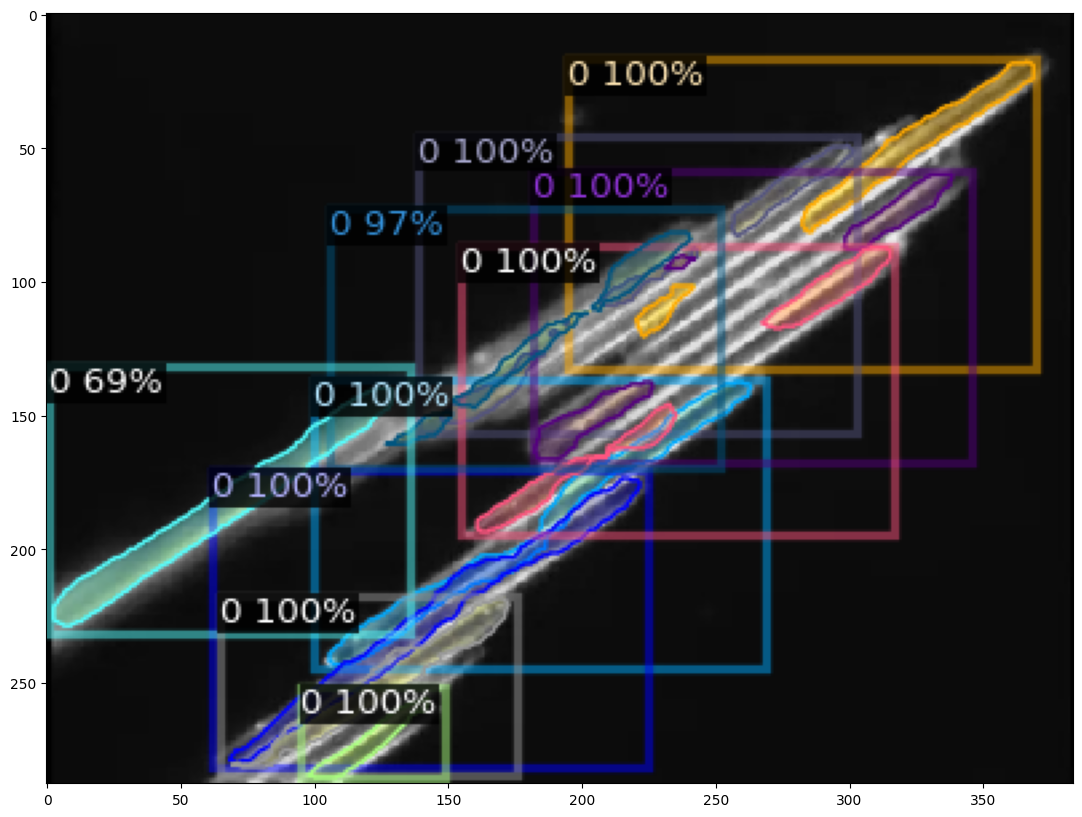

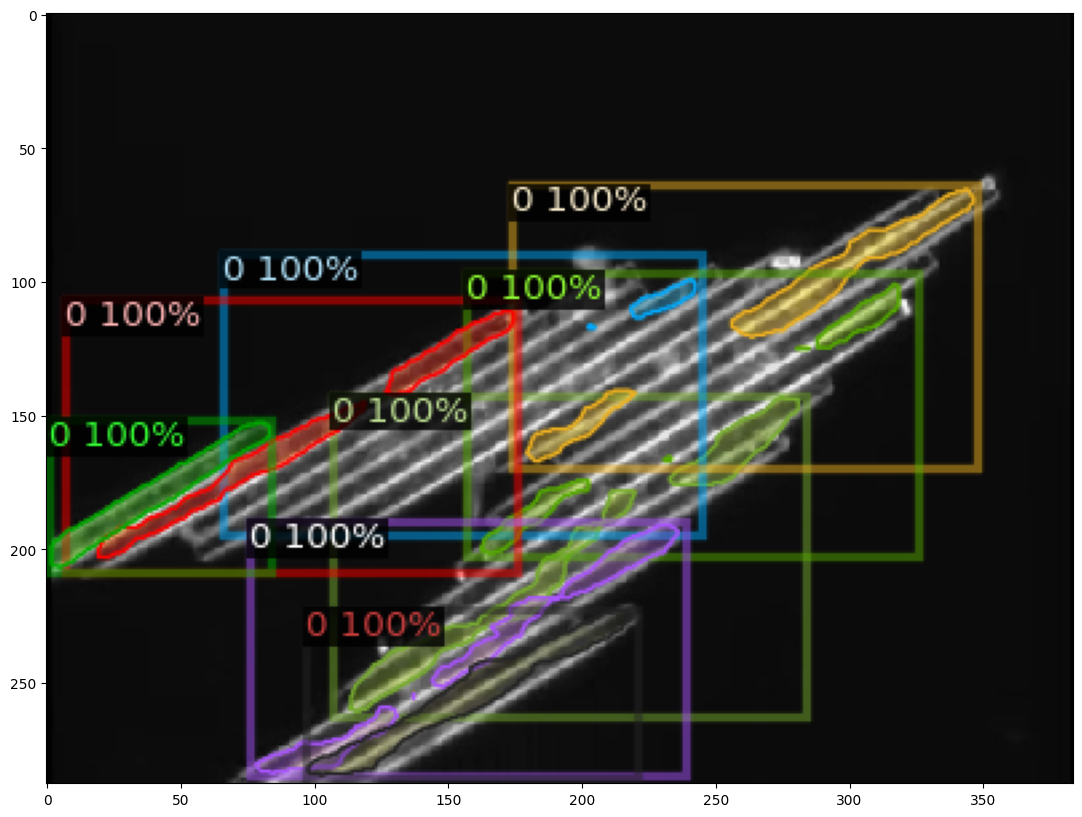

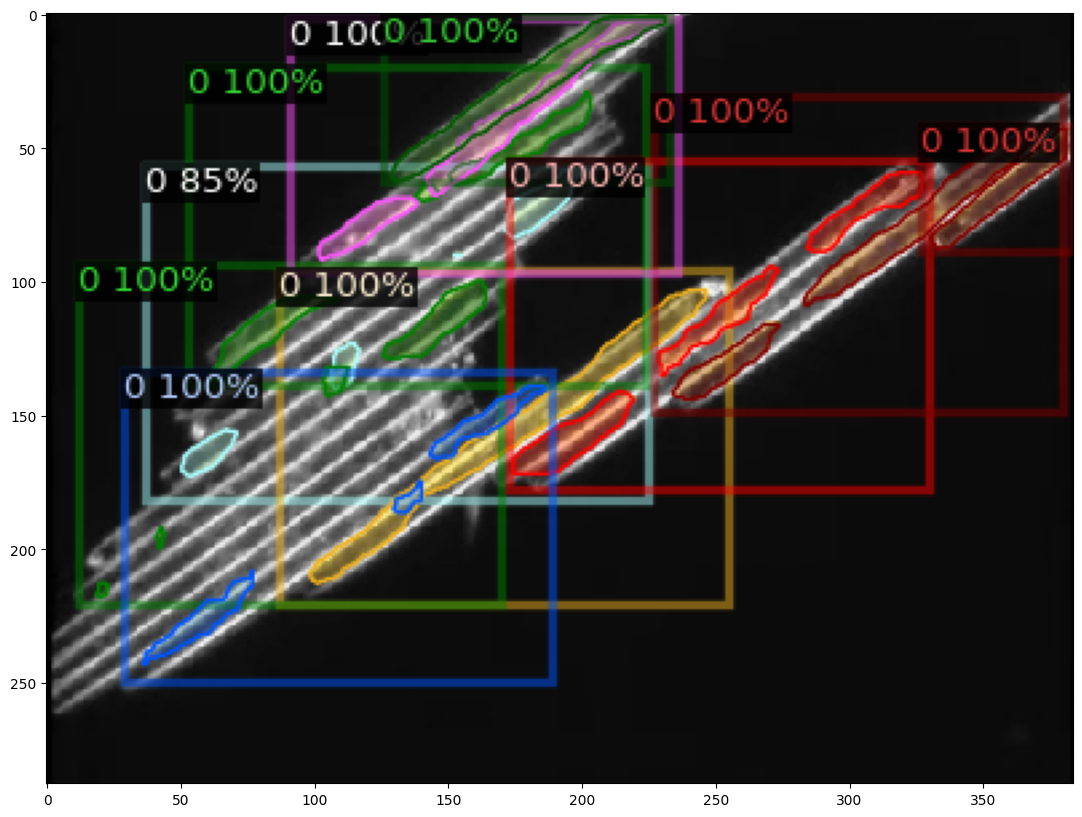

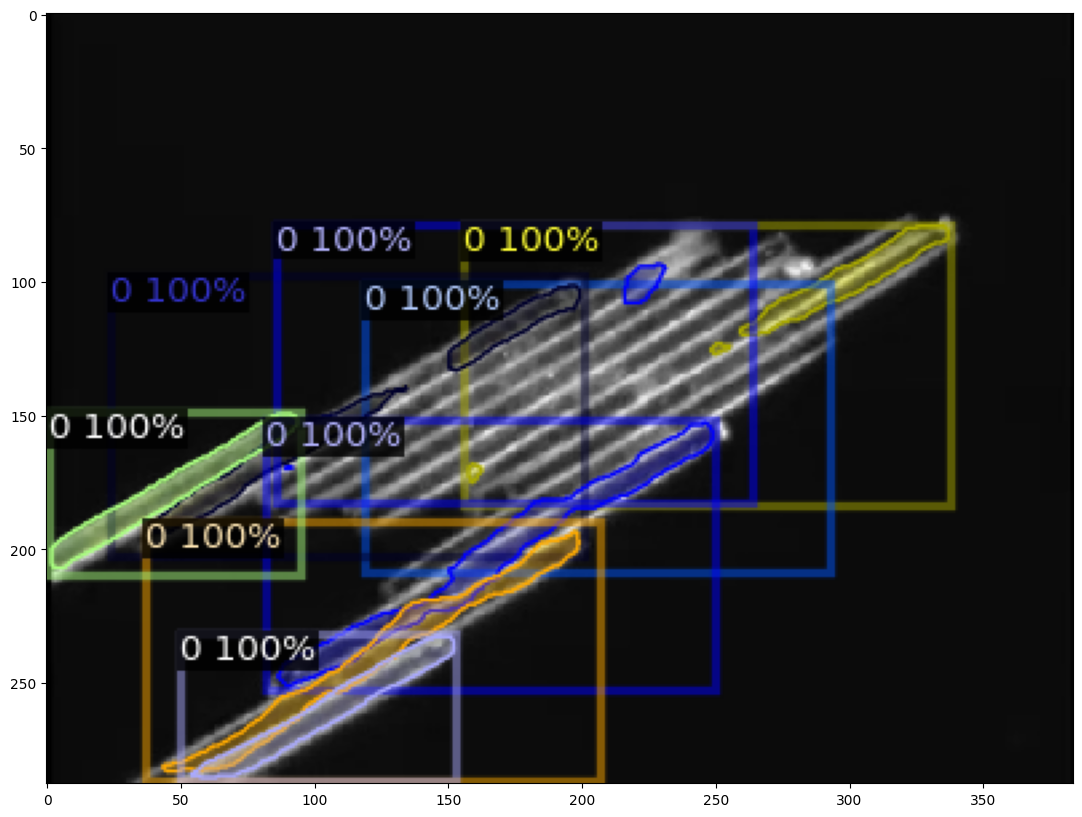

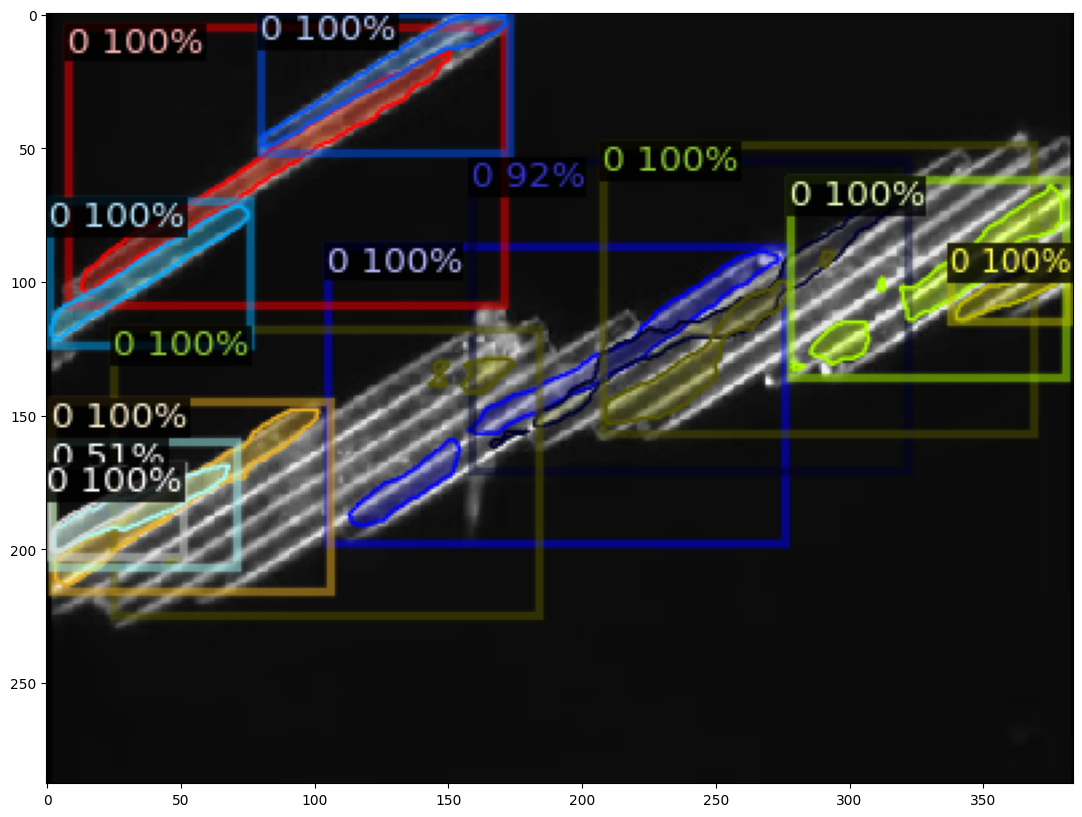

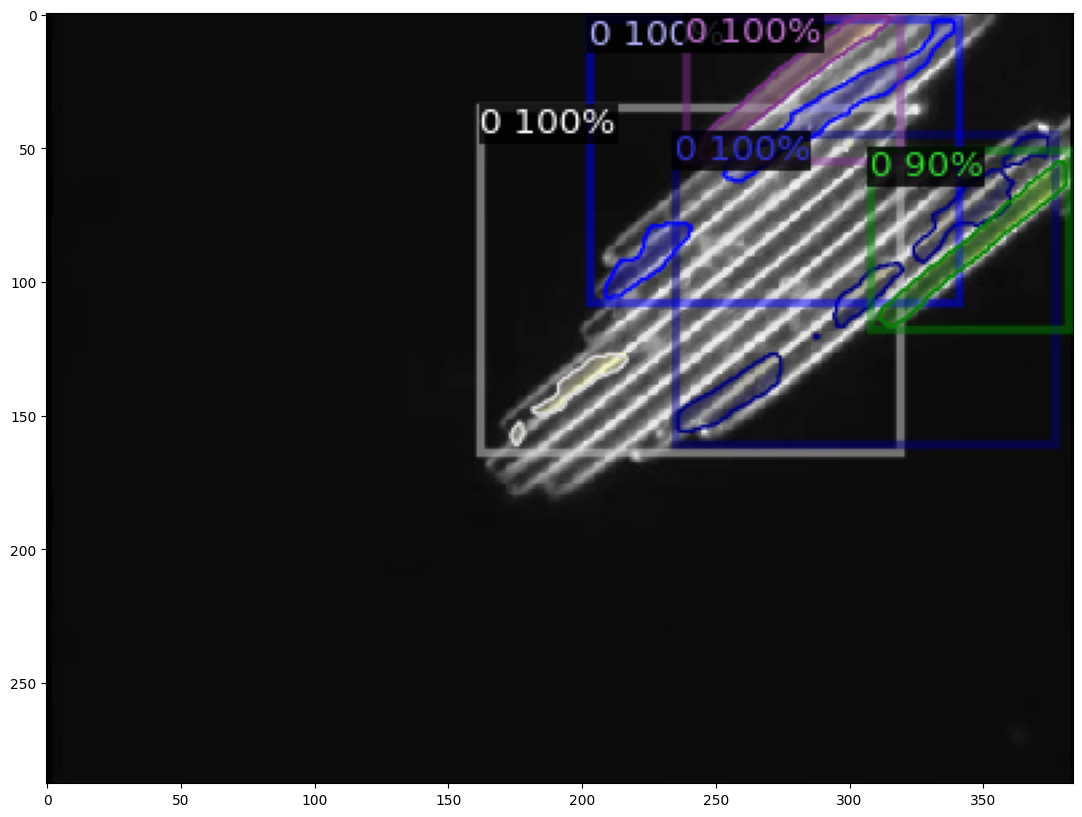

In [13]:
dataset_dicts = DatasetCatalog.get("diatom_seg_test")
for d in random.sample(dataset_dicts, 6):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()